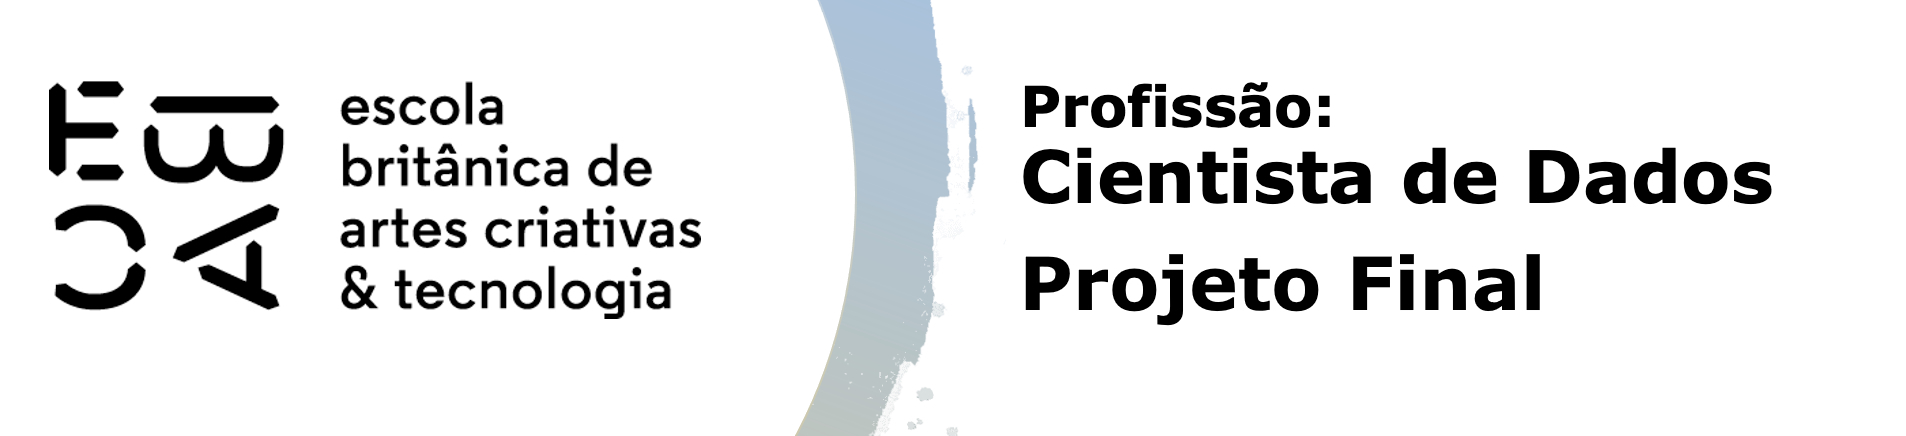

<hr>

# **Suposições do modelo e outliers**

As suposições do modelo são condições que se assumem como verdadeiras ao utilizar um determinado modelo estatístico. Elas servem como base para a aplicação de testes e inferências estatísticas. Quando essas suposições são violadas, os resultados da análise podem ser enganosos, comprometendo a confiabilidade das conclusões.

Cada observação deve ser independente das demais. Isso significa que o valor de uma observação não deve influenciar o valor de outra. A estatísticas deve seguir uma distribuição normal, em forma de sino. Essa suposição é importante para calcular intervalos de confiança e realizar testes de hipóteses. A variância dos erros deve ser constante ao longo de todos os valores da variável independente. Essa suposição é crucial para garantir a precisão das estimativas dos parâmetros do modelo. Já os outliers podem influenciar de forma desproporcional os resultados da análise e distorcer as conclusões.

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
import statsmodels.api as sm 
import warnings
from classes.utils import read_object, write_object
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import OLSInfluence as olsi
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [101]:
# Definindo a lista de variáveis que serão usadas no modelo junto com aquelas definidas pela etapa do PCA
variaveis = read_object('variaveis')
variaveis = ['bairro', 'tipo', 'valor_log', 'quartos', 'metro_quadrado_cat'] + variaveis['variaveis_pca']

In [102]:
# lendo os dados apenas com as colunas necessárias
df_base = pd.read_feather('./dataset/aluguel_rio_pca.feather')
df_base.reset_index(inplace=True)
df = df_base[['id'] + variaveis].copy()

In [103]:
# lista completo com todas as variáveis
print(variaveis, end='')

['bairro', 'tipo', 'valor_log', 'quartos', 'metro_quadrado_cat', 'vagas', 'banheiros', 'metro_quadrado_log', 'metro_trem', 'elevador', 'animais_permitidos', 'mobiliado', 'cozinha', 'piscina', 'ar_condicionado', 'varanda', 'interfone', 'condominio_fechado', 'garagem']

In [104]:
# definindo os parâmetros do modelo que serão usados no statsmodels
parametos_modelo = ' + '.join([
     'C(tipo):C(metro_quadrado_cat)',
     'C(bairro):C(metro_quadrado_cat)',
     'C(tipo):vagas',
     'C(tipo):quartos',
     'C(tipo):banheiros',
     'metro_quadrado_log',
     'C(metro_trem)',
     'C(elevador)',
     'C(animais_permitidos)',
     'C(mobiliado)',
     'C(cozinha)',
     'C(piscina)',
     'C(ar_condicionado)',
     'C(varanda)',
     'C(interfone)',
     'C(condominio_fechado)',
     'C(garagem)'
])

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Acima foi definida a string dos parâmetros do modelo seguindo o padrão utilizado pelo statsmodels. Todas as variáveis binárias foram configuradas como categóricas, assim como o tipo e o bairro do imóvel. Para as variáveis vagas, quartos e banheiros, foi feito um relacionamento com o tipo do imóvel, como foi visto durante a análise exploratória bivariada. O tipo e o bairro do imóvel também foram relacionados ao metro quadrado categorizado do imóvel.

</div>

In [105]:
model = smf.ols(f'valor_log ~ {parametos_modelo}', data=df)
reg = model.fit()
summary = reg.summary()

In [106]:
summary.tables[0]

Dep. Variable:,valor_log,R-squared:,0.705
Model:,OLS,Adj. R-squared:,0.697
Method:,Least Squares,F-statistic:,95.05
Date:,"Sun, 28 Jul 2024",Prob (F-statistic):,0.00
Time:,00:27:41,Log-Likelihood:,-26385.
No. Observations:,23211,AIC:,5.391e+04
Df Residuals:,22642,BIC:,5.849e+04
Df Model:,568,,
Covariance Type:,nonrobust,,


In [107]:
summary.tables[2]

Omnibus:,2739.001,Durbin-Watson:,1.713
Prob(Omnibus):,0.000,Jarque-Bera (JB):,19029.398
Skew:,0.349,Prob(JB):,0.00
Kurtosis:,7.380,Cond. No.,6.73e+17


<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Podemos observar na tabela anterior que inicialmente tanto o R<sup>2</sup> quando o R<sup>2</sup> ajustado do modelo estão praticamente em de 70%.

</div>

## Distribuição Normal

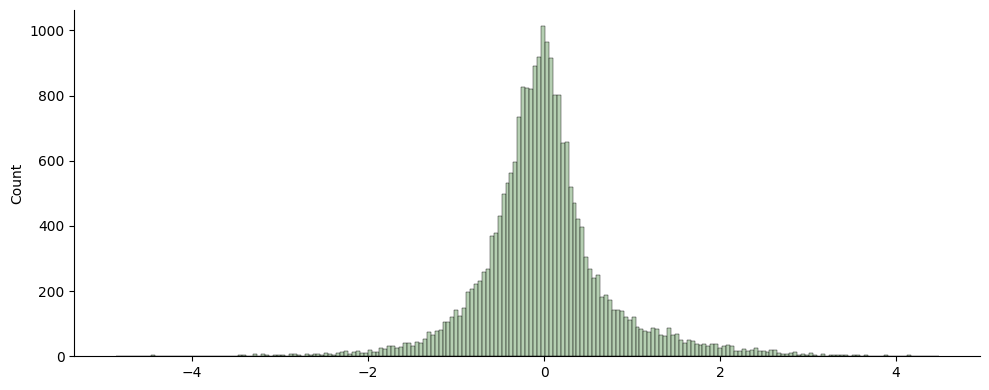

In [108]:
sns.displot(reg.resid, height=4, aspect=2.5, color='#9DC098');

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

O gráfico apresentado sugere uma boa aproximação à distribuição normal dos resíduos do modelo. A distribuição dos resíduos se assemelha à curva em formato de sino característica da distribuição normal. A maior parte dos dados se concentra ao redor do valor central (próximo a zero), com uma diminuição gradual na frequência à medida que se afastam desse valor. A distribuição parece ser aproximadamente simétrica em torno da média, o que é outro indicativo de normalidade. Há evidências de outliers, ou seja, valores que se desviam significativamente da maioria dos dados. Outliers serão analisados posteriormente.

</div>

## Independência

In [109]:
# recupera os valores preditos do modelo
preditos = reg.predict()

In [110]:
# cria um objetos de OLSInfluence
regsi = olsi(reg)

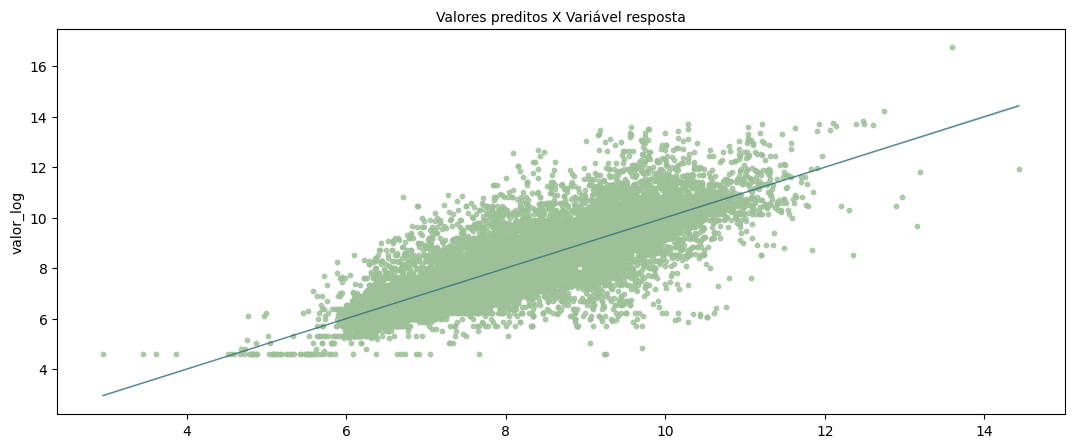

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
sns.regplot(
    ax=ax,
    x=preditos, 
    y=df['valor_log'], 
    color='#9DC098',
    scatter_kws={'alpha': 0.8, 's': 10}, 
    line_kws={'color': '#316E7E', 'lw': 1, 'alpha': 0.8}
);
ax.set_title("Valores preditos X Variável resposta", fontsize=10);

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

A nuvem de pontos se concentra ao redor de uma reta com inclinação positiva, indicando uma relação direta entre as variáveis. A dispersão dos pontos em torno da reta central sugere que a relação não é perfeita, ou seja, existem variações nos dados que não são totalmente explicadas pela relação linear.

</div>

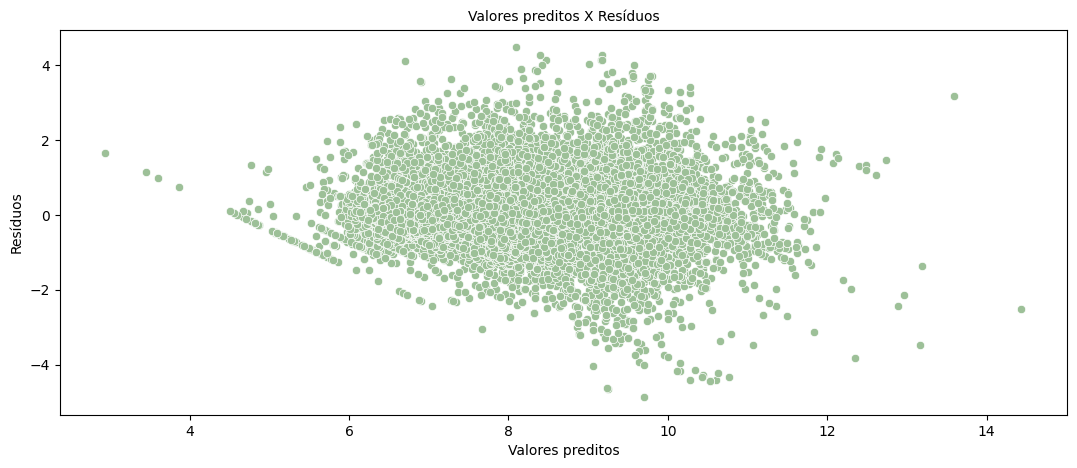

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
sns.scatterplot(x=preditos, y=reg.resid, ax=ax, color='#9DC098')
ax.set_xlabel("Valores preditos")
ax.set_ylabel("Resíduos")
ax.set_title("Valores preditos X Resíduos", fontsize=10);

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Os resíduos apresentam variância relativamente constante (homocedasticidade). Isso sugere que a maior parte dos pontos de dados se ajusta bem ao modelo, com pouca variabilidade. O modelo pode estar capturando a maior parte da variabilidade dos dados, deixando poucos resíduos significativos. Mesmo assim, podemos ver que os pontos no gráfico não estão perfeitamente ajustados, podendo haver algum padrão não linear nos resíduos que não está sendo capturado pelo modelo. Esses pondem ser ponto de outliers, que serão analisados a seguir.

</div>

## Outliers

In [113]:
# Calcular medidas de influência e outliers.
influence = reg.get_influence()

# matriz diagonal
hat_matrix_diag = influence.hat_matrix_diag

# resíduos studentizados 
studentized_residuals = influence.resid_studentized_internal

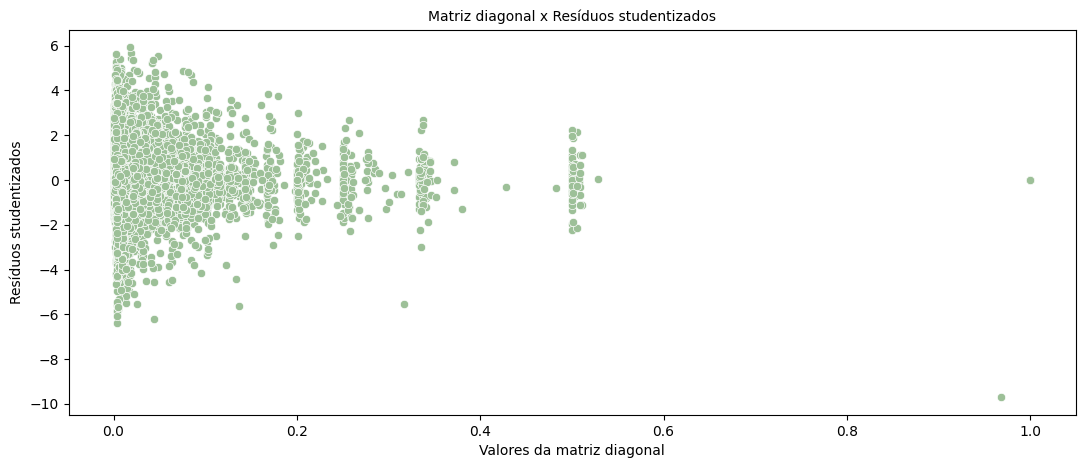

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
sns.scatterplot(x=hat_matrix_diag, y=studentized_residuals, ax=ax, color='#9DC098')
ax.set_xlabel('Valores da matriz diagonal')
ax.set_ylabel('Resíduos studentizados')
ax.set_title('Matriz diagonal x Resíduos studentizados', fontsize=10);

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Pontos localizados à direita do gráfico, com valores altos na matriz diagonal, exercem maior influência nas estimativas dos coeficientes de regressão. Eles podem "puxar" a reta de regressão em sua direção, distorcendo os resultados. Existem 2 pontos na extremidade direita do gráfico. Pontos localizados na parte superior ou inferior do gráfico, com valores altos em módulo dos resíduos studentizados, são considerados outliers. Eles se desviam significativamente da tendência geral dos dados. A presença de pontos com altos valores absolutos de resíduos studentizados indica a existência de outliers.

</div>

Abaixo será feita uma análise de alguns pontos do gráfico que podem ser considerados outliers.



In [115]:
# função para retornar os índices dos pontos de influência com base no leverage
def recuperar_pontos_influencia(modelo, hleverage_inf = None, hleverage_sup = None):
    leve = []; stde = [];
    if hleverage_inf != None:
        leve = [i for i, k in enumerate(modelo.hat_matrix_diag) if k >= hleverage_inf]
    if hleverage_sup != None:
        stde = [i for i, k in enumerate(modelo.hat_matrix_diag) if k <= hleverage_sup]
    if hleverage_inf != None and hleverage_sup != None:
        conjunto_a = set(leve)
        conjunto_b = set(stde)
        return list(conjunto_a.intersection(conjunto_b))
    if hleverage_inf != None:
        return leve
    if hleverage_sup != None:
        return stde

# função para retornar um dataframe dos pontos de influência
def criar_dataframe_out(hleverage_inf = None, hleverage_sup = None):
    pontos = recuperar_pontos_influencia(regsi, hleverage_inf, hleverage_sup)
    return df_base.iloc[pontos].copy().sort_values('bairro')[['id', 'bairro', 'tipo', 'valor', 'metro_quadrado']]

In [116]:
# criando um dataframe com os registros dos imóveis aparecem no gráfico acima de 0.2
df_out = criar_dataframe_out(.2) 
df_out

,id,bairro,tipo,valor,metro_quadrado
51,11271,Alto da Boa Vista,Casa,1450,80
22470,34511,Alto da Boa Vista,Apartamento,2200,68
20287,32320,Alto da Boa Vista,Apartamento,2600,154
8741,20646,Alto da Boa Vista,Casa,4000,260
19082,31109,Alto da Boa Vista,Casa,15000,600
...,...,...,...,...,...
21693,33732,Vila Valqueire,Loja,4000,45
3919,15351,Vila Valqueire,Loja,7500,46
6432,18109,Vila Valqueire,Terreno,25000,480
9339,21260,Vila Valqueire,Loja,6300,84


<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Acima de 0.2 no eixo X do gráfico temos 407 imóveis. Abaixo será criado um dataframe com os limites do boxplot para detecção de outliers para cada bairro e tipo. Esse novo dataframe será usado para verificar se os pontos no gráfico são realmente outliers, se estiverem fora desse intervalo.
</div>

In [120]:
# cria um dataframe com os dados do boxplot/quartis com os limites para detecção dos outliers por bairro e tipo
df_limites = df_base[['bairro', 'tipo', 'valor']].groupby(['bairro', 'tipo']).describe(percentiles=[.25, .75]).reset_index()
df_limites['q1']  = df_limites['valor']['25%']
df_limites['q3']  = df_limites['valor']['75%']
df_limites['iqr'] = df_limites['q3'] - df_limites['q1']
df_limites['inf'] = df_limites['q1'] - (1.5 * df_limites['iqr'])
df_limites['sup'] = df_limites['q3'] + (1.5 * df_limites['iqr'])
df_limites['inf'] = np.where((df_limites['inf']<0), (df_limites['sup']-df_limites['valor']['std']), df_limites['inf'])
df_limites = df_limites[['bairro', 'tipo', 'inf', 'sup']]
df_limites.columns = ['bairro', 'tipo', 'inf', 'sup']
df_limites.head(10)

,bairro,tipo,inf,sup
0,Alto da Boa Vista,Apartamento,2012.500000,3112.50
1,Alto da Boa Vista,Casa,11244.724799,16650.00
2,Alto da Boa Vista,Casa de Condomínio,20000.000000,20000.00
3,Alto da Boa Vista,Loja,3125.000000,20925.00
4,Anchieta,Apartamento,318.750000,1488.75
5,Anchieta,Casa,312.500000,1932.50
6,Anchieta,Casa de Vila,520.000000,520.00
7,Anchieta,Galpão,5500.000000,5500.00
8,Anchieta,Loja,1266.118953,2436.25
9,Anchieta,Sala Comercial,500.000000,500.00


<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Acima temos um exemplo da tabela de limites de outlier, para cada bairro e tipo. Inf e Sup na tabela significam o intervalo entre o primeiro e o terceiro quartil. Valores abaixo de Q1 - 1.5IQR ou acima de Q3 + 1.5IQR são considerados outliers.
</div>

Abaixo será criado um dataframe para verificar os pontos que de fato são outlier

In [121]:
# aqui faz um merge entre as tabela com os pontos outliers e a tabela de limites
df_outlier = pd.merge(df_out, df_limites, on=['bairro', 'tipo'])
df_outlier['valor'] = df_outlier['valor'].astype('float64')

# se o valor estiver fora do intervalo interquartil, é outlier
df_outlier['outlier'] = np.where(((df_outlier['valor'] >= df_outlier['inf']) & (df_outlier['valor'] <= df_outlier['sup'])), 0, 1)
df_outlier

,id,bairro,tipo,valor,metro_quadrado,inf,sup,outlier
0,11271,Alto da Boa Vista,Casa,1450.0,80,11244.724799,16650.0,1
1,34511,Alto da Boa Vista,Apartamento,2200.0,68,2012.500000,3112.5,0
2,32320,Alto da Boa Vista,Apartamento,2600.0,154,2012.500000,3112.5,0
3,20646,Alto da Boa Vista,Casa,4000.0,260,11244.724799,16650.0,1
4,31109,Alto da Boa Vista,Casa,15000.0,600,11244.724799,16650.0,0
...,...,...,...,...,...,...,...,...
402,33732,Vila Valqueire,Loja,4000.0,45,11163.600193,14625.0,1
403,15351,Vila Valqueire,Loja,7500.0,46,11163.600193,14625.0,1
404,18109,Vila Valqueire,Terreno,25000.0,480,25000.000000,25000.0,0
405,21260,Vila Valqueire,Loja,6300.0,84,11163.600193,14625.0,1


In [123]:
index_outliers = df_outlier.query('outlier == 1')['id']
len(index_outliers)

188

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Na etapa acima, foi verificado quais os pontos do gráfico eram outliers conforme o intervalo interquartil. Dos 407 registros iniciais, 188 foram considerados outliers e serão removidos da base dados.

</div>

In [128]:
# removendo os outliers da base de dados
df.drop(index=df.query('id in @index_outliers').index, inplace=True)

In [142]:
model_out = smf.ols(f'valor_log ~ {parametos_modelo}', data=df)
reg_out = model_out.fit()
summary_out = reg_out.summary()

In [143]:
# Calcular medidas de influência e outliers.
influence_out = reg_out.get_influence()

# matriz diagonal
hat_matrix_diag_out = influence_out.hat_matrix_diag

# resíduos studentizados 
studentized_residuals_out = influence_out.resid_studentized_internal

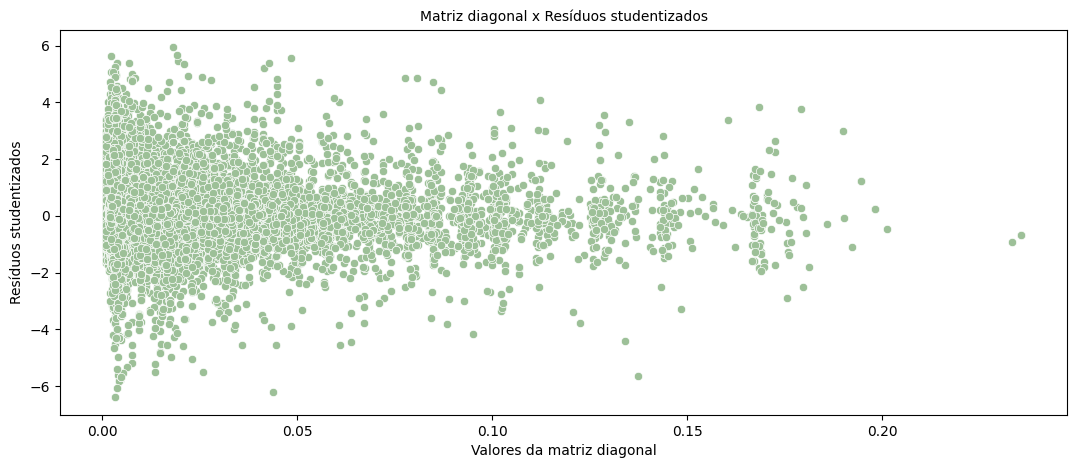

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
sns.scatterplot(x=hat_matrix_diag_out, y=studentized_residuals_out, ax=ax, color='#9DC098')
ax.set_xlabel('Valores da matriz diagonal')
ax.set_ylabel('Resíduos studentizados')
ax.set_title('Matriz diagonal x Resíduos studentizados', fontsize=10);

<div style="border: 1px solid #88AB8E; background-color: #ECF4E3; padding: 10px; border-radius: 5px;">

Podemos observar que os pontos antes considerados como outliers conforme o intervalo interquartil foram removidos.

</div>

## Salvando a base de dados <a name="Salvando-a-base-de-dados"></a>

A base de dados atualizada, com os outliers removidos, será gravada em formato feather para que possa ser utilizadas nas etapas seguintes.

In [147]:
df.to_feather('./dataset/aluguel_rio_modelo_final.feather')

A lista das variáveis e parâmetros do modelo também serão armazenados para serem utilizada posteriormente.

In [150]:
arquivo_vars = read_object('variaveis')
arquivo_vars['parametos_modelo'] = parametos_modelo
arquivo_vars['variaveis_modelo'] = variaveis
write_object('variaveis', arquivo_vars)